In [18]:
from typing import List, Tuple, Any

In [19]:
import requests
import json

In [20]:
query : dict[str, Any] = {
    "query" : {
        "type" : "group",
        "logical_operator" : "and",
        "nodes" : [
            {
                "type" : "terminal",
                "service" : "text",
                "parameters" : {
                    "attribute" : "rcsb_entry_info.resolution_combined",
                    "operator" : "range",
                    "value" : {
                        "from" : 1,
                        "to" : 3,
                        "include_lower" : True,
                        "include_upper" : True
                    }
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "rcsb_entity_source_organism.taxonomy_lineage.name",
                    "operator": "exact_match",
                    "value": "Homo sapiens"
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "rcsb_entry_info.selected_polymer_entity_types",
                    "operator": "exact_match",
                    "value": "Protein (only)"
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "rcsb_struct_symmetry.type",
                    "operator": "exact_match",
                    "value": "Asymmetric"
                }
            },
            {
                "type": "terminal",
                "service": "text",
                "parameters": {
                    "attribute": "entity_poly.rcsb_sample_sequence_length",
                    "operator": "exists",
                }
            }
        ],
        "label" : "text"
    },
    "return_type": "entry",
    "request_options": {
        "paginate": {
            "rows": 10000,
            "start": 0
        },
        "results_content_type": [
            "experimental"
        ],
        "sort": [
            {
                "sort_by": "score",
                "direction": "desc"
            }
        ],
        "scoring_strategy": "combined"
    }
}

In [21]:
request_url = "https://search.rcsb.org/rcsbsearch/v2/query"

In [22]:
first_req = requests.get(request_url, params = {"json": json.dumps(query, separators=(',', ':'))})

In [23]:
identifiers : List[str] = []
for entry in first_req.json()["result_set"]:
    identifiers.append(entry["identifier"])

In [24]:
for i in range(10000, first_req.json()["total_count"], 10000):
    query["request_options"]["paginate"]["start"] = i
    req = requests.get(request_url, params = {"json": json.dumps(query, separators=(',', ':'))})
    for entry in req.json()["result_set"]:
        identifiers.append(entry["identifier"])

In [25]:
from Bio.PDB import PDBList, PDBParser
from Bio.PDB.DSSP import DSSP

In [26]:
pdb_list = PDBList(server="https://files.wwpdb.org/")
parser = PDBParser()

In [27]:
pdb_list.download_pdb_files(identifiers, pdir="pdb_files", file_format="pdb", overwrite=False)

Structure exists: 'pdb_files/pdb134l.ent' Structure exists: 'pdb_files/pdb1a08.ent' 
Structure exists: 'pdb_files/pdb1a09.ent' 
Structure exists: 'pdb_files/pdb1a1b.ent' 
Structure exists: 'pdb_files/pdb12ca.ent' 
Structure exists: 'pdb_files/pdb1a1a.ent' 
Structure exists: 'pdb_files/pdb133l.ent' 
Structure exists: 'pdb_files/pdb1a07.ent' 
Structure exists: 'pdb_files/pdb1a1c.ent' 

Structure exists: 'pdb_files/pdb1a1e.ent' 
Structure exists: 'pdb_files/pdb1a1m.ent' 
Structure exists: 'pdb_files/pdb1a1o.ent' 
Structure exists: 'pdb_files/pdb1a28.ent' 
Structure exists: 'pdb_files/pdb1a22.ent' 
Structure exists: 'pdb_files/pdb1a2b.ent' 
Structure exists: 'pdb_files/pdb1a3b.ent' 
Structure exists: 'pdb_files/pdb1a1n.ent' 
Structure exists: 'pdb_files/pdb1a2c.ent' 
Structure exists: 'pdb_files/pdb1a3e.ent' 
Structure exists: 'pdb_files/pdb1a4w.ent' 
Structure exists: 'pdb_files/pdb1a4v.ent' 
Structure exists: 'pdb_files/pdb1a42.ent' 
Structure exists: 'pdb_files/pdb1a46.ent' 
Structure e

In [28]:
import os
from multiprocess import Pool, cpu_count

In [29]:
def get_seq_and_ss(id : str) -> Tuple[str, str] | None:
    try:
        file_name = f"pdb_files/pdb{id.lower()}.ent"
        if not os.path.exists(file_name):
            return None
        structure = parser.get_structure(id, file_name)
        model = structure[0]
        dssp = DSSP(model, file_name, dssp="mkdssp", file_type="PDB")
        seq = ""
        ss = ""
        for i in range(len(dssp)):
            a_key = list(dssp.keys())[i]
            seq += dssp[a_key][1]
            ss += dssp[a_key][2]
        
        return (seq, ss)
    except Exception as e:
        return None


In [30]:
data : List[Tuple[str, str, str]] = []
failed_identifiers : List[str] = []

In [ ]:
max_pool = cpu_count() - 1

with Pool(max_pool) as p:
    results = p.map(get_seq_and_ss, identifiers)

In [34]:
for i in range(len(identifiers)):
    if results[i] is None or results[i][0] == "" or results[i][1] == "":
        failed_identifiers.append(identifiers[i])
    else:
        data.append((identifiers[i], results[i][0], results[i][1]))

In [35]:
with open("data.csv", "w") as f:
    f.write("identifier,sequence,secondary_structure\n")
    for identifier, sequence, secondary_structure in data:
        f.write(f"{identifier},{sequence},{secondary_structure}\n")

In [36]:
import pandas as pd

In [59]:
# Read data back once calculations are done to avoid re-running the above code

df = pd.read_csv("data.csv")
data = df.to_records(index=False).tolist()

(array([1.1408e+04, 2.9146e+04, 1.3700e+04, 7.1280e+03, 4.8100e+03,
        2.2420e+03, 2.8920e+03, 1.2360e+03, 7.3200e+02, 4.6400e+02,
        3.8800e+02, 1.8000e+02, 1.3000e+02, 8.8000e+01, 1.0800e+02,
        8.0000e+01, 4.4000e+01, 4.6000e+01, 4.6000e+01, 4.0000e+01,
        3.8000e+01, 6.0000e+00, 2.4000e+01, 8.0000e+00, 2.6000e+01,
        1.2000e+01, 8.0000e+00, 1.0000e+01, 8.0000e+00, 2.0000e+00,
        6.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+01, 1.4000e+01, 1.2000e+01]),
 array([4.00000e+00, 1.83320e+02, 3.62640e+02, 5.41960e+02, 7.21280e+02,
        9.00600e+02, 1.07992e+03, 1.25924e+03, 1.43856e+03, 1.61788e+03,
        1.79720e+03, 1.97652e+03, 2.15584e+03, 2.33516e+03, 2.51448e+03,
        2.69380e+03, 2.87312e+03, 3.05244e+03, 3.23176e+03, 3.41108e+03,
        3.59040e+03, 3.769

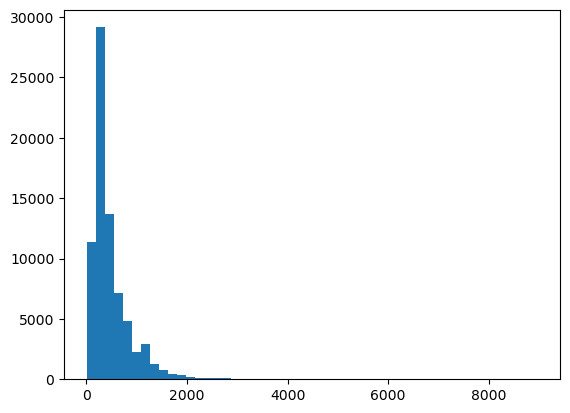

In [ ]:
# Histogram of sequence lengths
import matplotlib.pyplot as plt
import numpy as np

sequence_lengths = [len(sequence) for _, sequence, _ in data]
plt.hist(sequence_lengths, bins=50)

(array([ 160.,  882., 5812., 4228., 3702., 9546., 8994., 6106., 4756.,
        3426., 3324., 2652., 2162., 2132., 1666., 1480.,  804., 1444.,
        1156., 1236.,  860.,  536.,  464.,  588.,  534., 1056.,  640.,
         306.,  754.,  278.,  544.,  214.,  128.,  172.,  168.,  194.,
         202.,  160.,   86.,  130.,   76.,  106.,  136.,   84.,   58.,
          80.,   36.,   26.,   38.,   44.]),
 array([   4.  ,   47.72,   91.44,  135.16,  178.88,  222.6 ,  266.32,
         310.04,  353.76,  397.48,  441.2 ,  484.92,  528.64,  572.36,
         616.08,  659.8 ,  703.52,  747.24,  790.96,  834.68,  878.4 ,
         922.12,  965.84, 1009.56, 1053.28, 1097.  , 1140.72, 1184.44,
        1228.16, 1271.88, 1315.6 , 1359.32, 1403.04, 1446.76, 1490.48,
        1534.2 , 1577.92, 1621.64, 1665.36, 1709.08, 1752.8 , 1796.52,
        1840.24, 1883.96, 1927.68, 1971.4 , 2015.12, 2058.84, 2102.56,
        2146.28, 2190.  ]),
 <BarContainer object of 50 artists>)

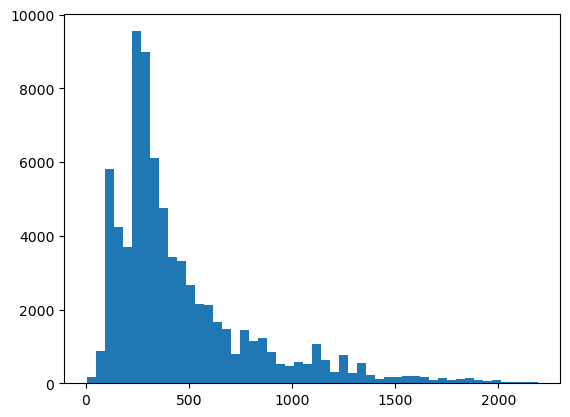

In [46]:
# Removing sequences lengths that are too long (outliers, utilizing the 99th percentile)
max_length = np.percentile(sequence_lengths, 99)

filtered_df = df[df['sequence'].apply(len) <= max_length]
filtered_data = filtered_df.to_records(index=False).tolist()

filtered_seq_lens = [len(sequence) for _, sequence, _ in filtered_data]
plt.hist(filtered_seq_lens, bins=50)

In [108]:
amino_acids = "ACDEFGHIKLMNPQRSTVXWY"
dssp_types = "GHITEBSP-"

In [109]:
def dist_graphs(df : pd.DataFrame):
    fig, axes = plt.subplots(3, figsize=(15, 15))
    sequence_lengths = df['sequence'].apply(len)
    axes[0].hist(sequence_lengths, bins=50)

    concatenated_sequences = ''.join(df['sequence'])
    concatenated_ss = ''.join(df['secondary_structure'])
    aa_counts = {aa: concatenated_sequences.count(aa) for aa in amino_acids}
    ss_counts = {ss: concatenated_ss.count(ss) for ss in dssp_types}
    axes[1].bar(aa_counts.keys(), aa_counts.values())
    axes[2].bar(ss_counts.keys(), ss_counts.values())

<BarContainer object of 9 artists>

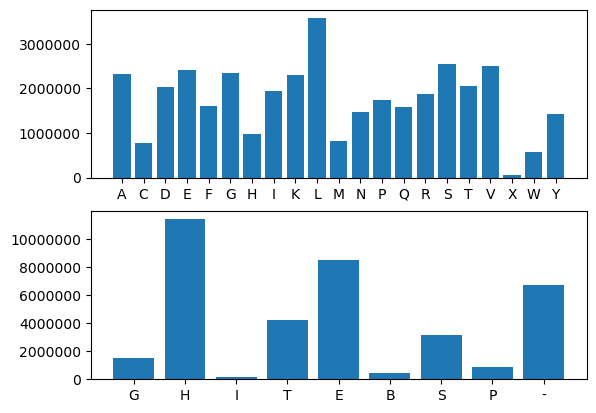

In [110]:
# Amino Acid and secondary structure counts for main data set
concatenated_sequences = "".join(df["sequence"])
concatentated_ss = "".join(df["secondary_structure"])
amino_acid_counts = {aa: concatenated_sequences.count(aa) for aa in amino_acids}
ss_counts = {ss: concatentated_ss.count(ss) for ss in dssp_types}
fig, ax2 = plt.subplots(2)
ax2[0].ticklabel_format(style='plain', axis='both')
ax2[0].bar(amino_acid_counts.keys(), amino_acid_counts.values())
ax2[1].ticklabel_format(style='plain', axis='both')
ax2[1].bar(ss_counts.keys(), ss_counts.values())

<BarContainer object of 9 artists>

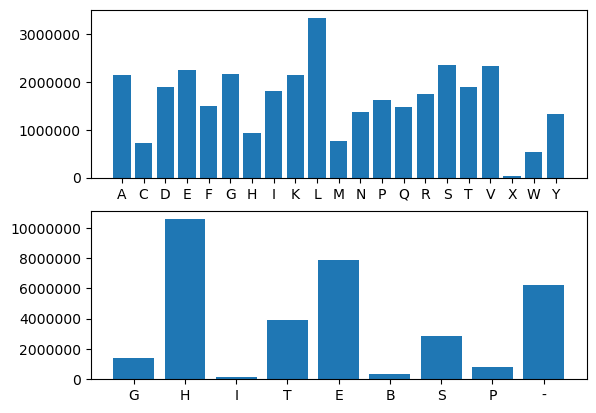

In [111]:
# Filtered Amino Acid and secondary structure counts
filtered_concatenated_sequences = "".join(filtered_df["sequence"])
filtered_concatenated_ss = "".join(filtered_df["secondary_structure"])
filtered_amino_acid_counts = {aa: filtered_concatenated_sequences.count(aa) for aa in amino_acids}
filtered_ss_counts = {ss: filtered_concatenated_ss.count(ss) for ss in dssp_types}
fig, ax3 = plt.subplots(2)
ax3[0].ticklabel_format(style='plain', axis='both')
ax3[0].bar(filtered_amino_acid_counts.keys(), filtered_amino_acid_counts.values())
ax3[1].ticklabel_format(style='plain', axis='both')
ax3[1].bar(filtered_ss_counts.keys(), filtered_ss_counts.values())

In [112]:
filtered_df.to_csv("filtered_data.csv", index=False)

In [113]:
def train_val_test_split(df: pd.DataFrame, val_size: float, test_size: float, strat_col: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    rng = np.random.default_rng()
    df = df.copy()

    for label, group in df.groupby(strat_col):
        idx = group.index.to_numpy()
        rng.shuffle(idx)
        n = len(idx)
        n_val = int(n * val_size)
        n_test = int(n * test_size)
        n_train = n - n_val - n_test
        df.loc[idx[:n_train], 'split'] = 'train'
        df.loc[idx[n_train:n_train + n_val], 'split'] = 'val'
        df.loc[idx[n_train + n_val:], 'split'] = 'test'

    df = df.sample(frac=1)

    return df[df['split'] == 'train'], df[df['split'] == 'val'], df[df['split'] == 'test']

In [114]:
# Splitting data into training, validation, and test sets
# Should split where lengths are roughly equal distribution-wise
# As well as the secondary structure distribution and amino acid distribution

from sklearn.cluster import KMeans

num_len_strata = 50
num_aa_strata = 25
num_ss_strata = 10

filtered_df.loc[:, 'len_bin'] = pd.cut(filtered_df['sequence'].apply(len), bins=num_len_strata, labels=False)

for aa in amino_acids:
    filtered_df.loc[:, aa] = filtered_df.loc[:, 'sequence'].apply(lambda x: x.count(aa))
for ss in dssp_types:
    filtered_df.loc[:, ss] = filtered_df.loc[:, 'secondary_structure'].apply(lambda x: x.count(ss))

aaKMeans = KMeans(n_clusters=num_aa_strata)
filtered_df.loc[:,'aa_cluster'] = aaKMeans.fit_predict(filtered_df.loc[:, [aa for aa in amino_acids]])
ssKMeans = KMeans(n_clusters=num_ss_strata)
filtered_df.loc[: ,'ss_cluster'] = ssKMeans.fit_predict(filtered_df.loc[:, [ss for ss in dssp_types]])

filtered_df.loc[:, 'strata'] = filtered_df.loc[:, 'len_bin'].astype(str) + "_" + filtered_df.loc[:, 'aa_cluster'].astype(str) + "_" + filtered_df.loc[:, 'ss_cluster'].astype(str)

train_df, val_df, test_df = train_val_test_split(filtered_df, 0.1, 0.1, 'strata')

train_df = train_df.loc[:, ['identifier', 'sequence', 'secondary_structure']]
val_df = val_df.loc[:, ['identifier', 'sequence', 'secondary_structure']]
test_df = test_df.loc[:, ['identifier', 'sequence', 'secondary_structure']]

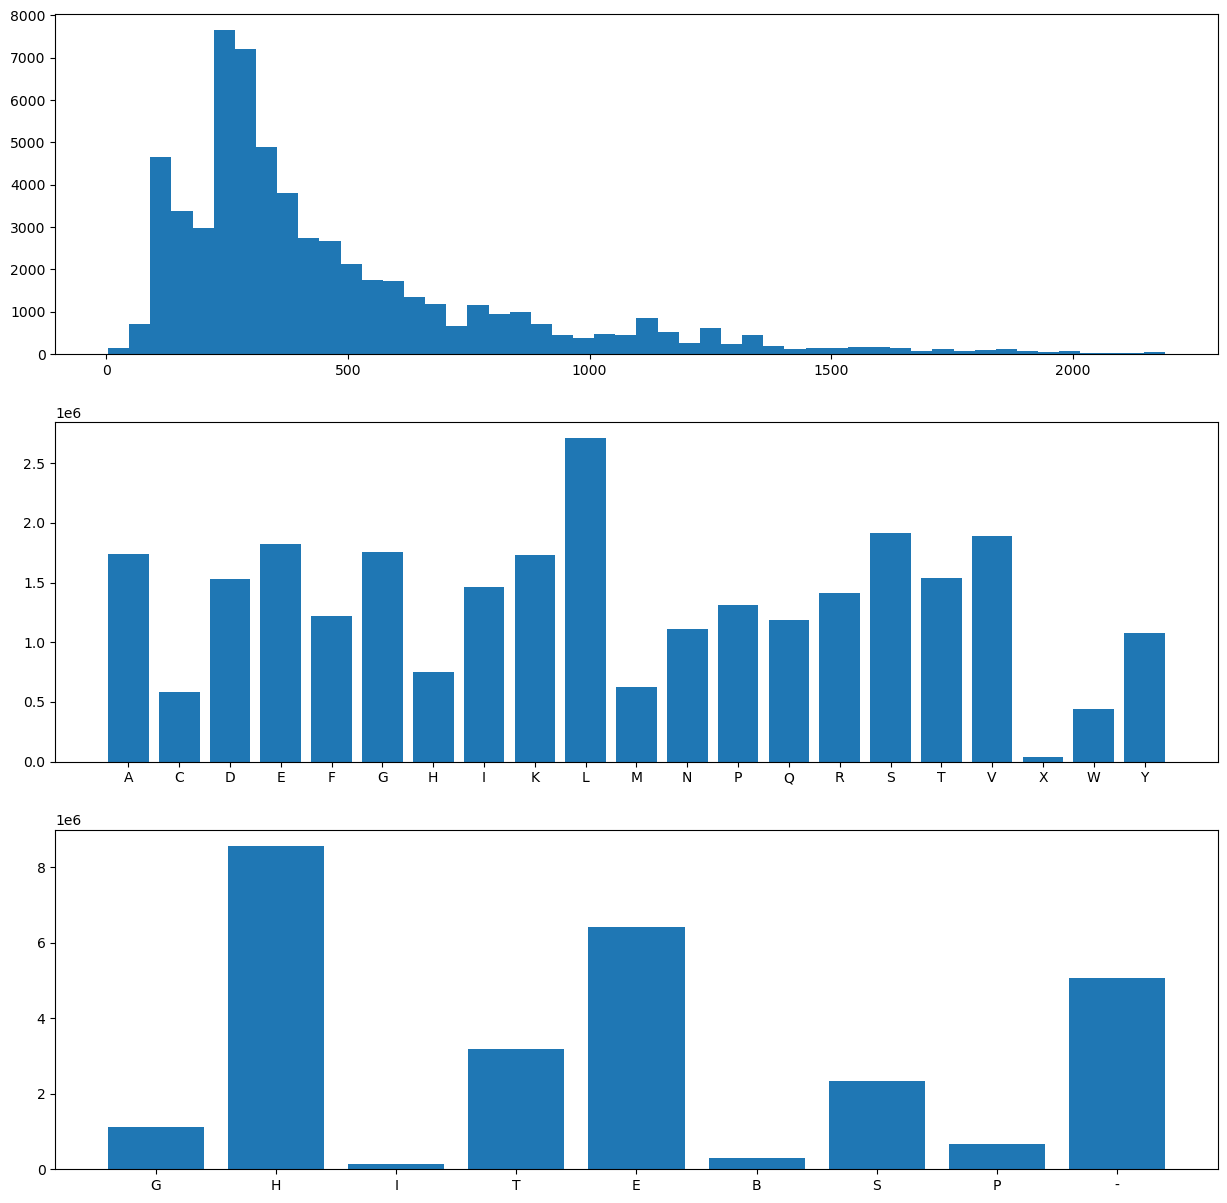

In [115]:
dist_graphs(train_df)

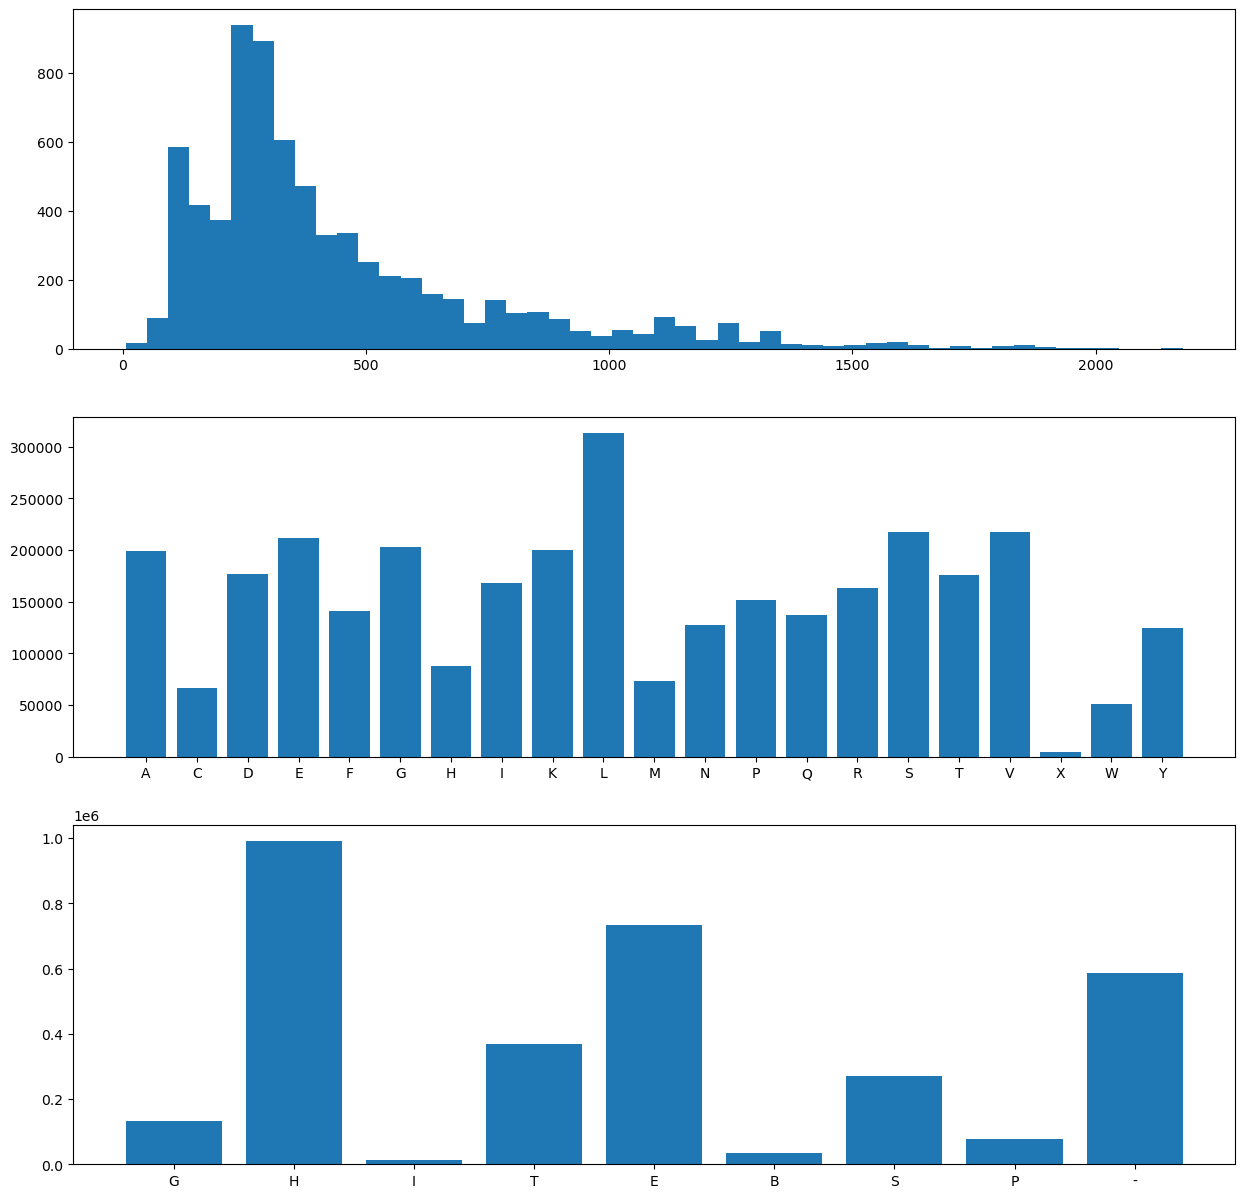

In [116]:
dist_graphs(val_df)

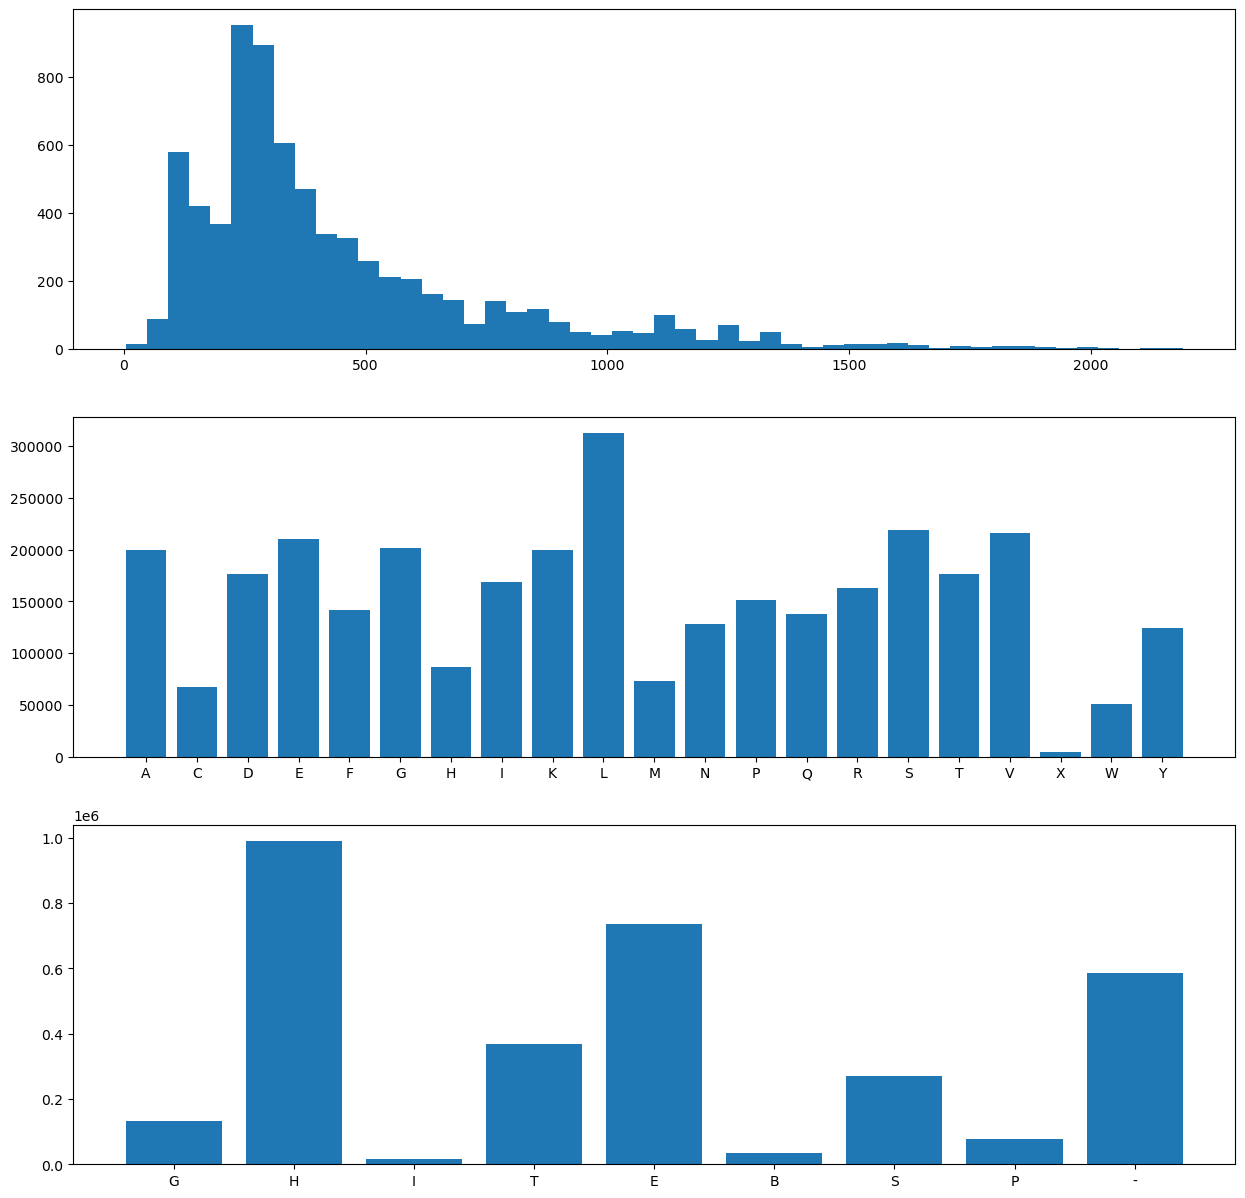

In [117]:
dist_graphs(test_df)

In [118]:
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)